In [1]:
using LinearAlgebra
#make sure to cite this package
using SPICE
using Downloads: download 
using DifferentialEquations
using Plots

In [2]:
using SatelliteDynamics

In [3]:
iss1 = [6371e3 + 500e3, 0.0004879, 90.6391, 194.5859, 151.2014, 190];
eci0_1 = sOSCtoCART(iss1, use_degrees=true)
T_iss = orbit_period(iss1[1])

5668.144371194183

In [4]:
eci0_1

6-element Vector{Float64}:
    -6.291285386249863e6
    -1.66264810311861e6
    -2.2161566541800327e6
 -2394.9708335284654
  -540.1532693380549
  7206.151917789134

In [5]:
epc0 = Epoch(2019, 1, 1, 12, 0, 0, 0.0)

Epoch(2019-01-01T11:59:23.000Z)

In [6]:
epcf = epc0 + T_iss

Epoch(2019-01-01T13:33:51.144Z)

In [7]:
orb1  = EarthInertialState(epc0, eci0_1, dt=1.0,
                               mass=1.0, n_grav=0, m_grav=0,
                               drag=false, srp=false,
                               moon=false, sun=false,
                               relativity=false)

EarthInertialState(SatelliteDynamics.RK4(SatelliteDynamics.fderiv_earth_orbit, Base.Pairs{Symbol, Real, NTuple{8, Symbol}, NamedTuple{(:mass, :n_grav, :m_grav, :drag, :srp, :moon, :sun, :relativity), Tuple{Float64, Int64, Int64, Vararg{Bool, 5}}}}(:mass => 1.0, :n_grav => 0, :m_grav => 0, :drag => false, :srp => false, :moon => false, :sun => false, :relativity => false)), 1.0, Epoch(2019-01-01T11:59:23.000Z), [-6.291285386249863e6, -1.66264810311861e6, -2.2161566541800327e6, -2394.9708335284654, -540.1532693380549, 7206.151917789134], nothing)

In [8]:
t_1, epc_1, eci_1 = sim!(orb1, epcf);

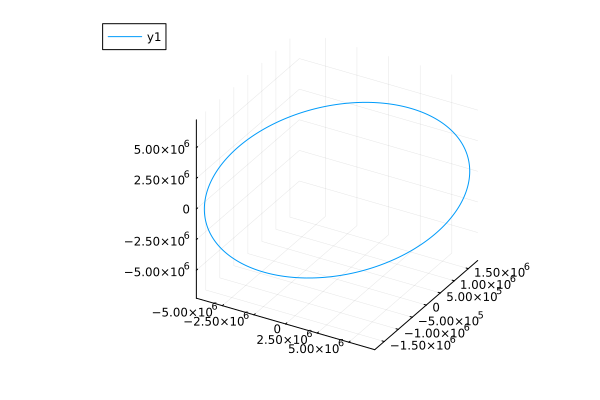

In [9]:
plot(eci_1[1,:], eci_1[2,:], eci_1[3,:])

In [10]:
# const LSK = "https://naif.jpl.nasa.gov/pub/naif/generic_kernels/lsk/naif0012.tls"
# const SPK = "https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/de440.bsp"

"https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/de440.bsp"

In [11]:
# # Download kernels
# #Time Kernel
# download(LSK, "naif0012.tls")

# #JPL planetary and lunar ephermis de440
# #Contains the orbit of all the planets
# # from years 1549 to 2650 

# download(SPK, "de440.bsp")

"de440.bsp"

In [12]:
# Load leap seconds kernel
#furnsh("/home/faustovega/Desktop/astrodynamics_nasa_work/naif0012.tls")

#laptop
furnsh("/home/fausto/naif0012.tls")

In [13]:
# Convert the calendar date to ephemeris seconds past J2000
et = utc2et("2018-02-06T20:45:00")

5.712219691849319e8

In [14]:
# Load a planetary ephemeris kernel
#furnsh("/home/faustovega/Desktop/astrodynamics_nasa_work/de440.bsp")


furnsh("/home/fausto/de440.bsp")

In [544]:
#gravitational parameters for the bodies (km3/s2)

#moon 
μ_m = 4902.80058214776

#earth
μ_e = 398600.432896939

#sun
μ_s = 132712440017.987

1.32712440017987e11

In [545]:
#units used to normalize
#also in km and seconds

#distance
l_star = 385692.50

#time
t_star = 377084.152667038

#in km
lunar_radius = 1738.2 

1738.2

In [546]:
#get the jacobian that maps from rotating frame to inertial frame
function get_transformation(time)

    #time is already wrt et
    
    #state of the moon (position and velocity) relative to Earth (in km and km/s)
    moon_state = spkezr("moon",time,"J2000","NONE","earth")[1]

    #position of the moon relative to Earth
    r_moon = moon_state[1:3]

    #velocity of the moon relative to Earth
    v_moon = moon_state[4:6]

    #x component of the rotating frame expressed in inertial coordinates
    x̃ = r_moon/norm(r_moon)
    #z component of the rotating frame expressed in inertial coordinates
    z̃ = cross(r_moon, v_moon)/norm(cross(r_moon, v_moon))
    #x component of the rotating frame expressed in inertial coordinates
    ỹ = cross(z̃, x̃)

    #instantanous rotation matrix from rotating frame to inertial frame (centered at Earth)
    C = [x̃ ỹ z̃]

    #instantanous angular velocity
    #θ_dot = norm(cross(r_moon, v_moon))/(norm(r_moon)^2)

    θ_dot = (cross(r_moon, v_moon)/(norm(r_moon)^2))[3]


    return C, θ_dot

end

get_transformation (generic function with 1 method)

In [547]:
C,_ = get_transformation(et)

([-0.777764700772571 0.6251165530667585 0.06566098776356756; -0.6070372270527993 -0.7199290662653917 -0.3364638829329076; -0.16305788911978802 -0.30154839516763404 0.9394044337598281], 2.375357847149033e-6)

In [548]:
#transform the controls from the CR3BP units to inertial frame 

#U is a matrix of the controls you want to simulate in the ephemeris model 
function transform_controls(U, dt)

    #every control is associated with a timestep
    N = size(U)[2]

    U_ephem = zeros(3, N)

    time = et

    for i=1:N

        C, _ = get_transformation(time)

        U_ephem[:,i] = C*U[:,i] 

        time += dt

    end

    return U_ephem

end

transform_controls (generic function with 1 method)

In [549]:
#transformation between CR3BP and ephemeris J2000 frame centered at the moon 

#x -> state in the CR3BP units
#t -> time
#et is the start time

function cr3bp_to_ephem(x, t)

    time = et + t

    #println(time)

    C, θ_dot = get_transformation(time)

    C̄ = [θ_dot.*C[:,2] -θ_dot.*C[:,1]]

    #transformation matrix
    C̃ = [C zeros(3,3); C̄ zeros(3) C]

    display(C̃)

    #apply the rotation to get the state in the inertial frame
    x_ephem = C̃*x

    return x_ephem

end

    

cr3bp_to_ephem (generic function with 1 method)

In [550]:
#structure matches pavlak thesis
cr3bp_to_ephem([1.1808985497899205E+0, -2.5444988241150091E-26, 1.0295054075242347E-4, 3.3765359485568778E-15, -1.5585631393981156E-1, 5.5263881873244218E-18], 0)

6×6 Matrix{Float64}:
 -0.777765     0.625117     0.065661   0.0        0.0        0.0
 -0.607037    -0.719929    -0.336464   0.0        0.0        0.0
 -0.163058    -0.301548     0.939404   0.0        0.0        0.0
  1.48488e-6   1.84747e-6   0.0       -0.777765   0.625117   0.065661
 -1.71009e-6   1.44193e-6   0.0       -0.607037  -0.719929  -0.336464
 -7.16285e-7   3.87321e-7   0.0       -0.163058  -0.301548   0.939404

6-element Vector{Float64}:
 -0.9184544473859239
 -0.716884020233837
 -0.19245811259892254
 -0.09742660825641218
  0.11220347112444679
  0.04699737548496536

In [551]:
#solve using DifferentialEquations.jl
#the t here is somewhere from 0-period
function ephem_dynamics_scaled!(du, u, p, t)
    
    #du[1:6] = ephemeris_model_EarthMoon(u[1:6], t)
    #scaled version
    du[1:6] = scaled_ephemeris_dynamics(u[1:6], t)
    
    
end

ephem_dynamics_scaled! (generic function with 1 method)

In [552]:
#solve using DifferentialEquations.jl
#the t here is somewhere from 0-period
function ephem_dynamics!(du, u, p, t)
    
    #dependence on time
    du[1:6] = ephemeris_model_EarthMoon(u[1:6], t)
    
    #no dependence on time
    #du[1:6] = ephemeris_model_Earth(u[1:6])
    
end

ephem_dynamics! (generic function with 1 method)

In [553]:
#gets the state and for the entire solution

function get_state(solution)
    
    N = size(solution.u)[1]

    all_states = zeros(6, N)

    for i=1:N
        all_states[:,i] = solution.u[i][1:6]
    end
    
    #all states and all stm are functions of t
    #solution.t is the time
    return all_states
end

get_state (generic function with 1 method)

In [554]:
#integrate just the dynamics
#start pose and length of the integration

function just_dynamics_integrate_scaled(x_0, period)
    
    tspan = (0.0, period)
    prob = ODEProblem(ephem_dynamics_scaled!, x_0, tspan)
    sol = solve(prob, TsitPap8(), abstol=1e-12, reltol=1e-12)
    
    return sol
    
end

just_dynamics_integrate_scaled (generic function with 1 method)

In [555]:
#integrate just the dynamics
#start pose and length of the integration

function just_dynamics_integrate(x_0, period)
    
    tspan = (0.0, period)
    prob = ODEProblem(ephem_dynamics!, x_0, tspan)
    sol = solve(prob, TsitPap8(), abstol=1e-12, reltol=1e-12)
    
    return sol
    
end

just_dynamics_integrate (generic function with 1 method)

In [556]:
#just earth
function ephemeris_model_Earth(x)

    xdot = zeros(6)

    xdot[1:3] = x[4:6]

    #position of the spacecraft relative to the earth 
    r_qi = x[1:3]

    #time = et + t

    #print("TIME: ", time)

    #get positions of moon and sun relative to earth 
    #rqj_moon = spkpos("moon", time, "J2000", "none", "earth")[1]
    #rqj_sun = spkpos("sun", time, "J2000", "none", "earth")[1]
    
    #println("rqj moon: ", rqj_moon)
    #rij_moon = rqj_moon- r_qi 
    #rij_sun = rqj_sun-r_qi

    #r̈_qi - vectors that define the position of spacecraft (P_i)
    #relative to the central body (in this case the earth)

    #print("this is rqi: ", r_qi)
    #print("this is μ_e: ", μ_e)
    #just Earth and Moon
    xdot[4:6] = (-μ_e/(norm(r_qi))^3)*r_qi #+
                #μ_m.*((rij_moon/norm(rij_moon)^3)-(rqj_moon/norm(rqj_moon)^3));



    #print("this is xdot: ", xdot)
    #\ splits up into multiple lines (including the sun)
    # xdot[4:6] = (-μ_e/(norm(r_qi))^3)*r_qi + 
    #               μ_m.*((rij_moon/norm(rij_moon)^3)-(rqj_earth/norm(rqj_moon)^3)) +
    #             μ_s.*((rij_sun/norm(rij_sun)^3)-(rqj_sun/norm(rqj_sun)^3));


    return xdot

end

ephemeris_model_Earth (generic function with 1 method)

In [557]:
function ephemeris_model_EarthMoon(x, t)

    xdot = zeros(6)

    xdot[1:3] = x[4:6]

    #position of the spacecraft relative to the earth 
    r_qi = x[1:3]

    time = et + t

    #print("TIME: ", time)

    #get positions of moon and sun relative to earth 
    rqj_moon = spkpos("moon", time, "J2000", "none", "earth")[1]
    #rqj_sun = spkpos("sun", time, "J2000", "none", "earth")[1]
    
    #println("rqj moon: ", rqj_moon)
    rij_moon = rqj_moon- r_qi 
    #rij_sun = rqj_sun-r_qi

    #r_qi - vector that defines the position of the satellite wrt Earth
    #rqj is the position of a planetary body wrt satellite

    
    #print("this is rqi: ", r_qi)
    #print("this is μ_e: ", μ_e)
    #just Earth and Moon
    xdot[4:6] = (-μ_e/(norm(r_qi))^3)*r_qi + μ_m.*((rij_moon/norm(rij_moon)^3)-(rqj_moon/norm(rqj_moon)^3));
                



    #print("this is xdot: ", xdot)
    #\ splits up into multiple lines (including the sun)
    # xdot[4:6] = (-μ_e/(norm(r_qi))^3)*r_qi + 
    #               μ_m.*((rij_moon/norm(rij_moon)^3)-(rqj_earth/norm(rqj_moon)^3)) +
    #             μ_s.*((rij_sun/norm(rij_sun)^3)-(rqj_sun/norm(rqj_sun)^3));


    return xdot

end

ephemeris_model_EarthMoon (generic function with 1 method)

In [558]:
#the x is scaled here as well as the t 

function scaled_ephemeris_dynamics(x,t)

    q_original = zeros(eltype(x),3)
    v_original = zeros(eltype(x),3)

    q_original = x[1:3]*l_star 
    v_original = x[4:6]*(l_star/t_star)
    t_original = t*t_star

    x_original = [q_original; v_original]

    #original is in the CR3BP units
    ẋ_original = zeros(eltype(x),6)

    #calculate the original xdot (no scaling)

    ẋ_original = ephemeris_model_EarthMoon(x_original, t_original)
    
    #then scale the output
    v_scaled = ẋ_original[1:3]/(l_star/t_star)
    
    a_scaled = ẋ_original[4:6]/(l_star/(t_star)^2)

    ẋ_scaled = [v_scaled; a_scaled]

    return ẋ_scaled

end

scaled_ephemeris_dynamics (generic function with 1 method)

In [559]:
#Relative to the moon

# function ephemeris_model_EarthMoon(x, t)

#     xdot = zeros(6)

#     xdot[1:3] = x[4:6]

#     #position of the spacecraft relative to the moon 
#     r_qi = x[1:3]

#     time = et + t

#     rqj_earth = spkpos("earth", time, "J2000", "none", "moon")[1]
#     rqj_sun = spkpos("sun", time, "J2000", "none", "moon")[1]
    
#     rij_earth = rqj_earth- r_qi 
#     rij_sun = rqj_sun-r_qi

#     #r̈_qi - vectors that define the position of spacecraft (P_i)
#     #relative to the central body (in this case the moon)

#     #just Earth and Moon
#     xdot[4:6] = (-μ_m/(norm(r_qi))^3)*r_qi + 
#                 μ_e.*((rij_earth/norm(rij_earth)^3)-(rqj_earth/norm(rqj_earth)^3));




#     #\ splits up into multiple lines (including the sun)
#     # xdot[4:6] = (-μ_m/(norm(r_qi))^3)*r_qi + 
#     #             μ_e.*((rij_earth/norm(rij_earth)^3)-(rqj_earth/norm(rqj_earth)^3)) + 
#     #             μ_s.*((rij_sun/norm(rij_sun)^3)-(rqj_sun/norm(rqj_sun)^3));


#     return xdot

# end

In [560]:
L_cr = 3.850e5 #in km - distance between centers of m1 and m2
V_cr = 1.025 #in km/s - orbital velocity of m1
T_cr = 2.361e6 #in seconds - orbital period of m1 and m2
time_scale = T_cr/(2*pi)

375764.8206399649

In [561]:
L_nasa = 389703
T_nasa = 382981

382981

In [562]:
#mass paramter for earth moon
μ_earth_moon = 1.215058560962404E-2

0.01215058560962404

In [563]:
#position of Earth in rotating frame
pose_m1 = [-μ_earth_moon, 0, 0]

3-element Vector{Float64}:
 -0.01215058560962404
  0.0
  0.0

In [564]:
#periodic orbit initial condition in the CR3BP
#from notebook
x0_test = [1.1201297302380415,
 0.0,
 0.0059396759100811495,
 0.0,
 0.17677819141944426,
 0.0]

 x0_test_earthcentered = [x0_test[1:3] - pose_m1; x0_test[4:6]]

#in cr3bp units 
T_periodic = 3.414975413662902


################################################################################################################
#from https://ssd.jpl.nasa.gov/tools/periodic_orbits.html

#in nasa cr3bp units
# x0_test = [1.1808985497899205E+0, -2.5444988241150091E-26, 1.0295054075242347E-4, 3.3765359485568778E-15, -1.5585631393981156E-1, 5.5263881873244218E-18]

# x0_test_earthcentered = [x0_test[1:3] - pose_m1; x0_test[4:6]]

# T_periodic = 3.4155308065628454


#################################################################################################################

# have to dimensionalize the CR3BP variables before getting simulated with the ephemeris model
x0_dim = [x0_test_earthcentered[1:3]*L_nasa; x0_test_earthcentered[4:6]*(L_nasa/T_nasa)]

T_dim = T_periodic*T_nasa 


# #convert cr3bp state to ephemeris 
x_test_ephem = cr3bp_to_ephem(x0_dim, 0)

#x_test_ephem = [1000, 1000, 6371+500, 10,10,10]

#check on Earth orbit to find bugs
#x_test_ephem = eci0_1*1e-3
#T_periodic_s = 5668

#T_periodic_s = T_periodic*time_scale

6×6 Matrix{Float64}:
 -0.777765     0.625117     0.065661   0.0        0.0        0.0
 -0.607037    -0.719929    -0.336464   0.0        0.0        0.0
 -0.163058    -0.301548     0.939404   0.0        0.0        0.0
  1.48488e-6   1.84747e-6   0.0       -0.777765   0.625117   0.065661
 -1.71009e-6   1.44193e-6   0.0       -0.607037  -0.719929  -0.336464
 -7.16285e-7   3.87321e-7   0.0       -0.163058  -0.301548   0.939404

6-element Vector{Float64}:
 -343039.04933903593
 -268635.8355109836
  -69775.34021885064
       0.7676523949039347
      -0.8840835667657665
      -0.37030589990655915

In [565]:
# function regular_dynamics(x)

#     xdot = zeros(6)
    
#     xdot[1:3] = x[4:6]
    
#     xdot[4:6] = (-μ_e/norm(x[1:3])^3)*x[1:3]
    
#     return xdot

# end

In [566]:
# regular_dynamics(x_test_ephem)

In [567]:
# ephemeris_model_EarthMoon(x_test_ephem, 0)

In [568]:
x_test_ephem_scaled = [x_test_ephem[1:3]/l_star; x_test_ephem[4:6]/(l_star/t_star)]

T_ephem_scaled = T_dim/t_star

3.4683788476649937

In [569]:
# function RK4_integrator(x)

#     Δt = 1
#     f1 = ephemeris_model_Earth(x)
#     f2 = ephemeris_model_Earth(x+0.5*Δt*f1)
#     f3 = ephemeris_model_Earth(x+0.5*Δt*f2)
#     f4 = ephemeris_model_Earth(x+ Δt*f3)

#     xnext = x + (Δt/6.0)*(f1+2*f2+2*f3+f4)

#     return xnext

# end

In [570]:
# all_states_rk4 = zeros(6, 5668)

# all_states_rk4[:,1] = x_test_ephem

# for i=1:5668-1
#     all_states_rk4[:,i+1] = RK4_integrator(all_states_rk4[:,i])

# end

In [571]:
# plot(all_states_rk4[1,:], all_states_rk4[2,:], all_states_rk4[3,:])

In [575]:
#scaled version of dynamics
#sol = just_dynamics_integrate_scaled(x_test_ephem_scaled, T_ephem_scaled)

# km and seconds
sol = just_dynamics_integrate(x0_dim, T_dim)

all_states = get_state(sol)

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase /home/faustovega/.julia/packages/SciMLBase/QSc1r/src/integrator_interface.jl:579


6×877356 Matrix{Float64}:
 -0.889411  -0.889403   -0.889384  …     -3.41724e-6     -3.73989e-6
 -0.696503  -0.696505   -0.696499         3.43671e-6      3.44893e-6
 -0.180909  -0.180911   -0.18091          1.47162e-6      1.49988e-6
  0.750519   2.04733     3.63638         -3.94638e5      -3.86177e5
 -0.864352   0.151196    1.39561      18949.2         10800.5
 -0.362041  -0.0982626   0.224964  …  35987.8         32471.8

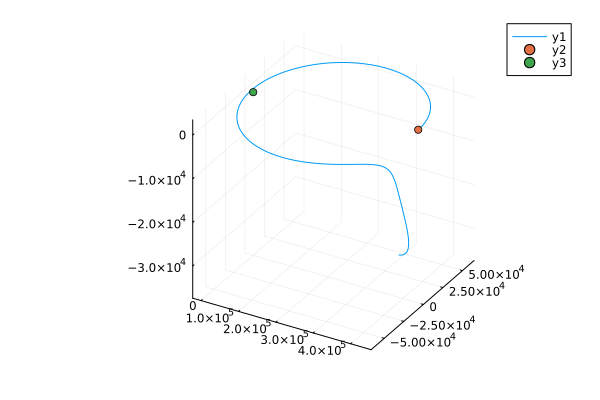

In [574]:
plot(all_states[1,:], all_states[2,:], all_states[3,:]) 
scatter!([all_states[1,1]], [all_states[2,1]], [all_states[3,1]])
scatter!([0], [0], [0])

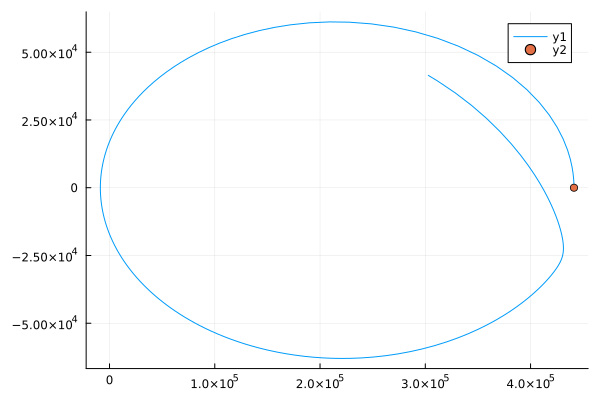

In [528]:
plot(all_states[1,:], all_states[2,:]) 

scatter!([all_states[1,1]], [all_states[2,1]]) 

In [ ]:
# plot(all_states[1,:]*l_star, all_states[2,:]*l_star, all_states[3,:]*l_star) 
# scatter!([all_states[1,1]*l_star], [all_states[2,1]*l_star], [all_states[3,1]*l_star])
#scatter!([0], [0], [0])

In [ ]:
# Get the position of Mars at `et` w.r.t. Earth

#arguments of this function
#spkpos(targ, et, ref, abcorr, obs)
#targ: target body name
#et: observer epoch
#ref: reference frame of output position vector
#abcorr: Aberration correction flag
#obs: Observing body name

#test = spkpos("mars_barycenter", et, "J2000", "none", "earth")

In [ ]:
# Get the state (km and km/s) of Mars at `et` w.r.t. Earth
#spkezr("mars_barycenter", et, "J2000", "none", "earth")

In [ ]:
rv_sun_eci, = spkezr("Sun",et,"J2000","NONE","Earth") # [km] and [km/s] position and velocity of the Sun in the ECI frame

In [ ]:
rv_sun_eci = spkezr("Sun",et,"J2000","NONE","Earth")[1][1:3]

In [ ]:
#I think the current problem is the integration is not good bc of the units